<!-- ---
title: "Week 6"
title-block-banner: true
title-block-style: default
execute:
  freeze: true
  cache: true
format: html
# format: pdf
--- -->

In [1]:
dir <- "~/work/courses/stat380/weeks/week-12/"
# renv::activate(dir)


#### Packages we will require this week

In [236]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "repr",
    "tidyverse",
    "kableExtra",
    "IRdisplay",
    "car",
    "corrplot",
    # NEW
    "torch",
    "torchvision",
    "luz",
    # Dimension reduction
    "dimRed",
    "RSpectra"
)

# renv::install(packages)
sapply(packages, require, character.only=TRUE)

ISLR2       dplyr       tidyr       readr       purrr        repr 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  tidyverse  kableExtra   IRdisplay         car    corrplot       torch 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
torchvision         luz      dimRed    RSpectra 
       TRUE        TRUE        TRUE        TRUE

---

# Tue, Apr 12

### Agenda:

1. Real-world neural network classification
1. Dataloaders
1. Torch for image classification

<br><br><br>

## Titanic

In [3]:
url <- "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

df <- read_csv(url) %>%
    mutate_if(\(x) is.character(x), as.factor) %>%
    mutate(y = Survived) %>%
    select(-c(Name, Survived)) %>%
    (\(x) {
        names(x) <- tolower(names(x))
        x
    })

df %>% head

Rows: 887 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Name, Sex
dbl (6): Survived, Pclass, Age, Siblings/Spouses Aboard, Parents/Children Ab...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pclass,sex,age,siblings/spouses aboard,parents/children aboard,fare,y
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,male,22,1,0,7.2500,0
1,female,38,1,0,71.2833,1
3,female,26,0,0,7.9250,1
1,female,35,1,0,53.1000,1
3,male,35,0,0,8.0500,0
3,male,27,0,0,8.4583,0


## Breast Cancer Prediction

In [4]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# col_names <- c("id", "diagnosis", paste0("feat", 1:30))

# df <- read_csv(
#         url, col_names, col_types = cols()
#     ) %>% 
#     select(-id) %>% 
#     mutate(y = ifelse(diagnosis == "M", 1, 0)) %>%
#     select(-diagnosis)


# df %>% head

### Train/Test Split

In [5]:
k <- 5

test_ind <- sample(
    1:nrow(df), 
    floor(nrow(df) / k),
    replace=FALSE
)

In [6]:
df_train <- df[-test_ind, ]
df_test  <- df[test_ind, ]

nrow(df_train) + nrow(df_test) == nrow(df)

[1] TRUE

### Benchmark with Logistic Regression

In [7]:
fit_glm <- glm(
    y ~ ., 
    df_train %>% mutate_at("y", factor), 
    family = binomial()
)

glm_test <- predict(
    fit_glm, 
    df_test,
    output = "response"
)

glm_preds <- ifelse(glm_test > 0.5, 1, 0)
table(glm_preds, df_test$y)

         
glm_preds  0  1
        0 99 30
        1 11 37

### Neural Net Model

In [8]:
NNet <- nn_module(
  initialize = function(p, q1, q2, q3) {  
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$output <- nn_linear(q3, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% self$activation() %>% 
      self$hidden2() %>% self$activation() %>% 
      self$hidden3() %>% self$activation() %>% 
      self$output() %>% self$sigmoid()
  }
)

### Fit using Luz

In [9]:
M <- model.matrix(y ~ 0 + ., data = df_train)

In [10]:
fit_nn <- NNet %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_bce_loss(),
        optimizer = optim_adagrad, 
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>% 
    #
    # Set the hyperparameters
    #
    set_hparams(p=ncol(M), q1=256, q2=128, q3=64) %>% 
    set_opt_hparams(lr=1e-2) %>% 
    #
    # Fit the model
    #
    fit(
        data = list(
            model.matrix(y ~ 0 + ., data = df_train),
            df_train %>% select(y) %>% as.matrix
        ),
        valid_data = list(
            model.matrix(y ~ 0 + ., data = df_test),
            df_test %>% select(y) %>% as.matrix
        ),
        epochs = 50, 
        verbose = TRUE
    )

Epoch 1/50
Train metrics: Loss: 0.913 - Acc: 12.3211
Valid metrics: Loss: 0.606 - Acc: 11.9435
Epoch 2/50
Train metrics: Loss: 0.6074 - Acc: 12.2845
Valid metrics: Loss: 0.6192 - Acc: 11.9435
Epoch 3/50
Train metrics: Loss: 0.5832 - Acc: 12.2845
Valid metrics: Loss: 0.592 - Acc: 11.9435
Epoch 4/50
Train metrics: Loss: 0.5862 - Acc: 12.3211
Valid metrics: Loss: 0.6622 - Acc: 11.9435
Epoch 5/50
Train metrics: Loss: 0.5741 - Acc: 12.3211
Valid metrics: Loss: 0.6079 - Acc: 11.9435
Epoch 6/50
Train metrics: Loss: 0.5698 - Acc: 12.3577
Valid metrics: Loss: 0.5968 - Acc: 11.9435
Epoch 7/50
Train metrics: Loss: 0.5587 - Acc: 12.3211
Valid metrics: Loss: 0.5851 - Acc: 11.9435
Epoch 8/50
Train metrics: Loss: 0.5617 - Acc: 12.2845
Valid metrics: Loss: 0.6103 - Acc: 11.9435
Epoch 9/50
Train metrics: Loss: 0.5326 - Acc: 12.3577
Valid metrics: Loss: 0.5509 - Acc: 11.9435
Epoch 10/50
Train metrics: Loss: 0.5199 - Acc: 12.3577
Valid metrics: Loss: 0.6454 - Acc: 11.9435
Epoch 11/50
Train metrics: Loss:

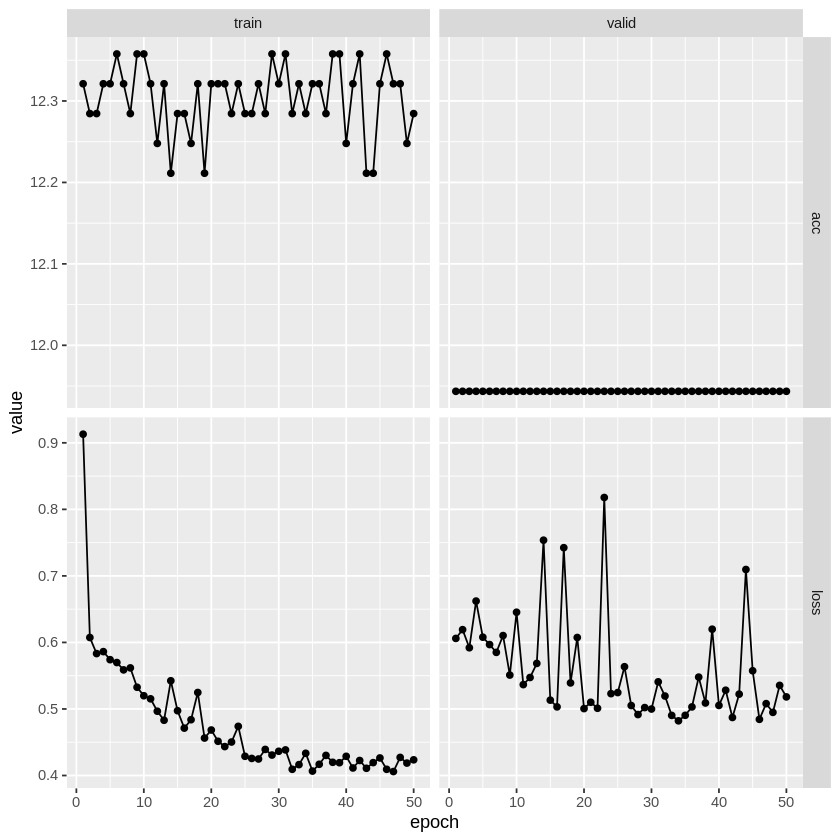

In [11]:
plot(fit_nn)

In [12]:
nn_test <- predict(
    fit_nn, 
    model.matrix(y ~ . - 1, data = df_test)
)
# nn_test
nn_preds <- ifelse(nn_test > 0.5, 1, 0)

table(nn_preds, df_test$y)
mean(nn_preds == df_test$y)

        
nn_preds   0   1
       0 100  28
       1  10  39

[1] 0.7853107

In [13]:
table(glm_preds, df_test$y)
mean(glm_preds == df_test$y)

         
glm_preds  0  1
        0 99 30
        1 11 37

[1] 0.7683616

<br><br><br><br>

---

### DataLoaders

* Dataloaders are a key component in the machine learning pipeline.

* They handle loading and preprocessing data in a way that is efficient for training and evaluating models.

* Dataloaders make it easy to work with large datasets by loading the data in smaller chunks (called **batches**) and applying transformations _on-the-fly_.


##### Why use Dataloaders?

> * **Efficient memory management:** loading data in smaller chunks reduces memory usage.
>
> * **Parallelism:**  supports asynchronous data loading for faster processing.
>
> * **Preprocessing:**  apply data transformations on-the-fly during training and evaluation.
>
> * **Flexibility:**  easily switch between different datasets or preprocessing steps.
>
> * **Standardization:**  consistent data format across various machine learning projects.
>

In [14]:
# ?dataloader

In [15]:
transform <- function(x) x %>% 
    torch_tensor() %>% 
    torch_flatten() %>% 
    torch_div(255)

In [16]:
dir <- "./mnist"

train_ds <- mnist_dataset(
  dir,
  download = TRUE,
  transform = transform
)

test_ds <- mnist_dataset(
  dir,
  download = TRUE,
  train = FALSE,
  transform = transform
)

In [17]:
typeof(train_ds)
length(train_ds)
train_ds$data[42000, ,]

[1] "environment"

[1] 60000

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,42,218,134,186,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,27,221,253,252,221,16,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,16,190,253,252,252,108,0,0,0
0,0,0,0,0,0,0,0,1,109,⋯,0,0,0,109,252,236,62,0,0,0
0,0,0,0,0,0,0,0,125,252,⋯,0,0,0,109,252,215,42,0,0,0
0,0,0,0,0,0,0,0,62,189,⋯,0,0,21,212,252,241,221,0,0,0


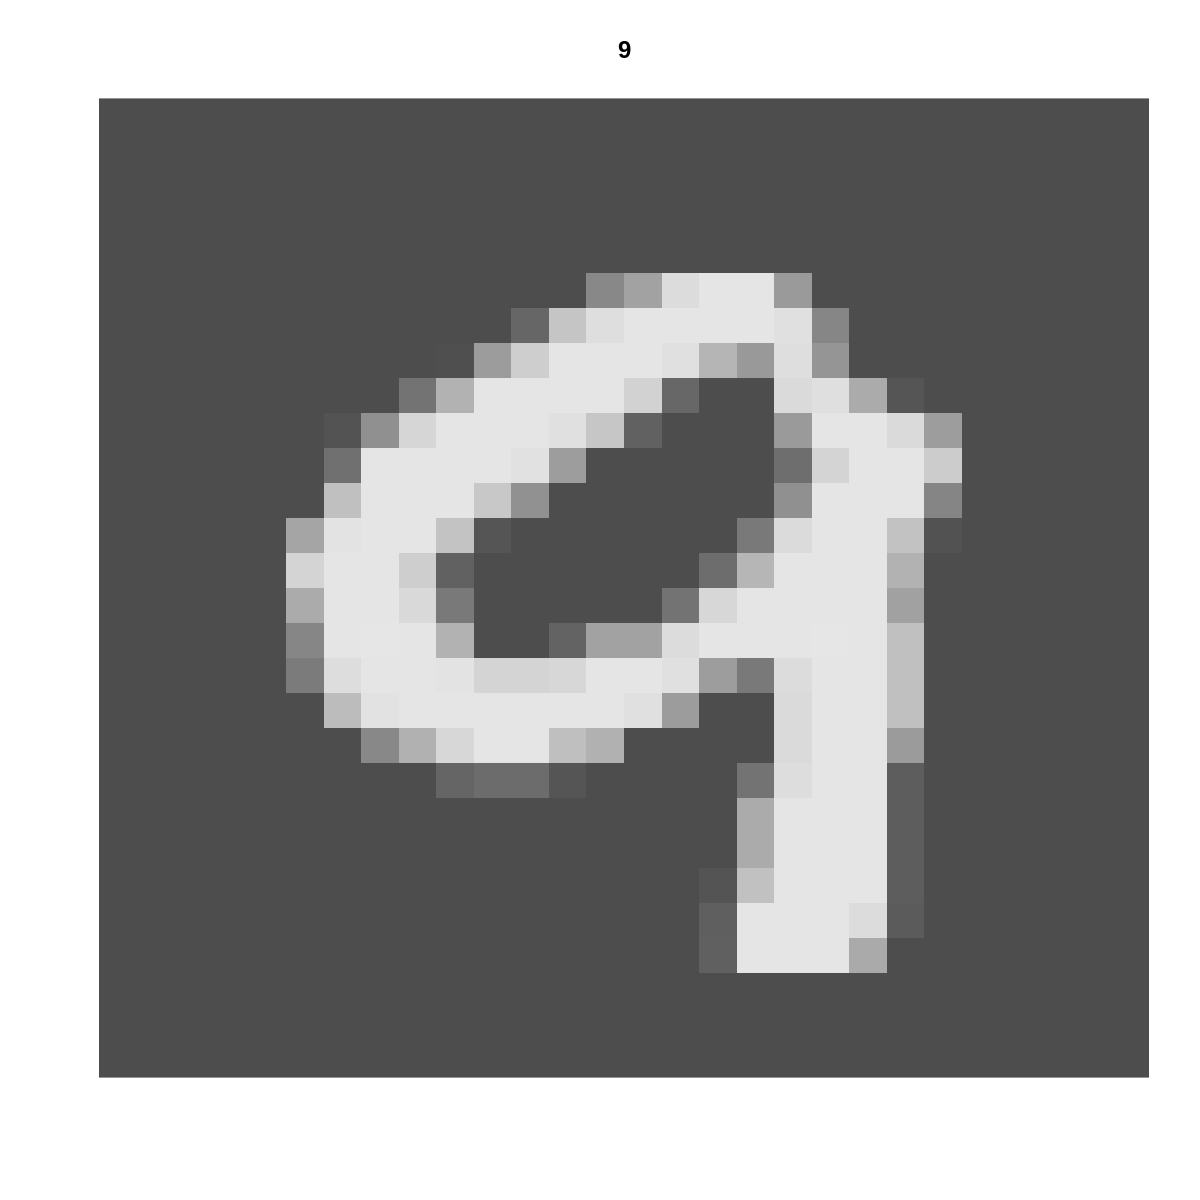

In [18]:
options(repr.plot.width=10, repr.plot.height=10)

i <- sample(1:length(train_ds), 1)
x <- train_ds$data[i, ,] %>% t

image(x[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000), main = train_ds$targets[i]-1 )

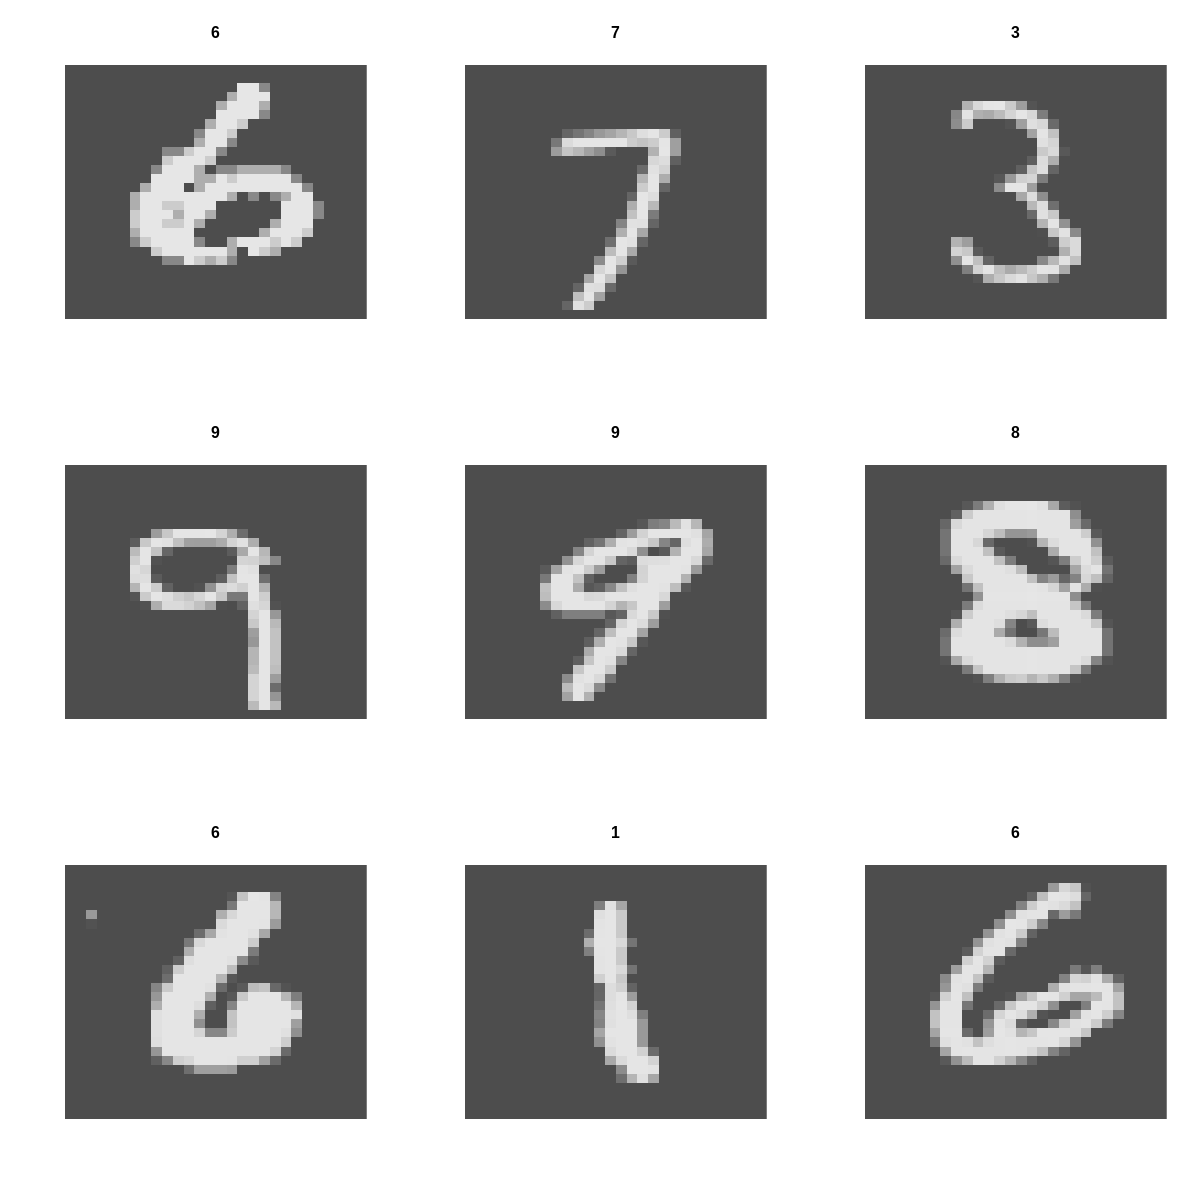

In [19]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(train_ds), 1)
    x <- train_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[i]-1)
}

<br><br><br><br>
<br><br><br><br>


---

# Image Classification

In [20]:
train_dl <- dataloader(train_ds, batch_size = 2000, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 2000)

In [21]:
NNet_10 <- nn_module(
  initialize = function(p, q1, q2, q3, o) {
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$OUTPUT <- nn_linear(q3, o)
    self$activation <- nn_relu()
  },
  forward = function(x) {
    x %>%
      self$hidden1() %>%
      self$activation() %>%
      self$hidden2() %>%
      self$activation() %>%
      self$hidden3() %>%
      self$activation() %>%
      self$OUTPUT()
  }
)

In [22]:
fit_nn <- NNet_10 %>%
    #
    # Setup the model
    #
    setup(
        loss = nn_cross_entropy_loss(),
        optimizer = optim_adam,
        metrics = list(
            luz_metric_accuracy()
        )
    ) %>%
    #
    # Set the hyperparameters
    #
    set_hparams(p=28*28, q1=256, q2=128, q3=64, o=10) %>% 
    #
    # Fit the model
    #
    fit(
        #
        # Training Data
        #
        epochs = 10,
        data = train_dl,
        # valid_data = test_dl,
        verbose=TRUE
    )

Epoch 1/10
Train metrics: Loss: 1.5052 - Acc: 0.6016
Epoch 2/10
Train metrics: Loss: 0.4157 - Acc: 0.878
Epoch 3/10
Train metrics: Loss: 0.3054 - Acc: 0.9108
Epoch 4/10
Train metrics: Loss: 0.2616 - Acc: 0.9244
Epoch 5/10
Train metrics: Loss: 0.2292 - Acc: 0.934
Epoch 6/10
Train metrics: Loss: 0.2013 - Acc: 0.9425
Epoch 7/10
Train metrics: Loss: 0.1812 - Acc: 0.9472
Epoch 8/10
Train metrics: Loss: 0.1621 - Acc: 0.953
Epoch 9/10
Train metrics: Loss: 0.1449 - Acc: 0.9582
Epoch 10/10
Train metrics: Loss: 0.1315 - Acc: 0.9618


In [23]:
NN10_preds <- fit_nn %>% 
  predict(test_ds) %>% 
  torch_argmax(dim = 2) %>%
  as_array()

In [24]:
NN10_preds <- NN10_preds -1 

In [25]:
table(
    NN10_preds %>% as.factor(),
    (test_ds$targets-1) %>% as.factor()
)

   
       0    1    2    3    4    5    6    7    8    9
  0  967    0    4    0    2    3   10    1    4    8
  1    0 1117    1    1    0    1    3    9    2    7
  2    2    3  998   15    3    0    3   15    5    2
  3    1    2    4  961    0   16    0    2   20   15
  4    0    0    5    0  952    2    5    0    6   22
  5    4    1    1   13    0  846   12    1    8    8
  6    2    4    5    0    8    9  922    0    9    0
  7    3    2    6    9    4    2    0  991    6   11
  8    1    6    6   11    2   10    3    1  913   13
  9    0    0    2    0   11    3    0    8    1  923

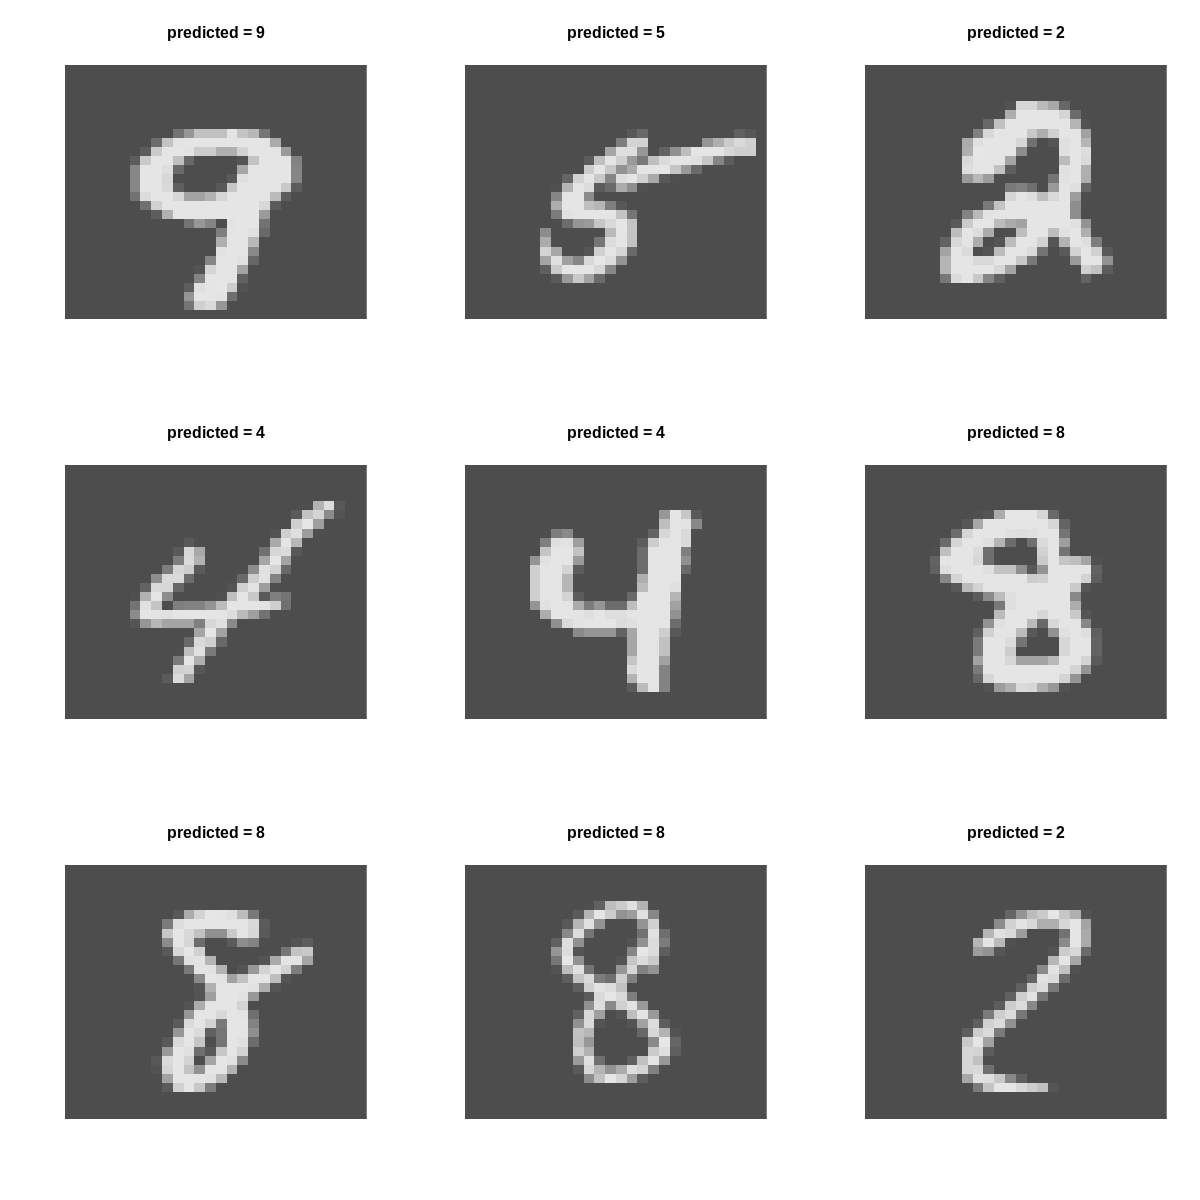

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow=c(3,3))

for(iter in 1:9){
    i <- sample(1:length(test_ds), 1)
    x <- test_ds$data[i, ,] %>% t
    image(x[1:28, 28:1], useRaster = TRUE, axes = FALSE, col = gray.colors(1000), main = paste("predicted =", NN10_preds[i]))
}

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

---

# Thu, Apr 13


## Supervised learning

For a majority of this course we have focused on **supervised learning** where we have access to **labelled data** i.e., we are given access to the _covariates and the responses_

<br><br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1}, y_1)\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2}, y_2)\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n}, y_n)
\end{aligned}
$$

<br><br><br>

Our **goal** has been to:

* Predict $y$ using $X_1, X_2, \dots X_p$
* Understand how each $X_i$ influences the response $y$

## Unsupervised learning

In unsupervised learning we **DON'T** have access to the labelled data, i.e., we are only given:

<br><br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1})\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2})\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n})
\end{aligned}
$$

<br><br><br>

Our **goal** here is:
* To understand the relationship between $X_1, X_2, \dots X_p$
    > * **dimension reduction**: 
    > 
    > Can we discover subgroups of variables $X_1, X_2, \dots X_p$ which behave similarly?
    
    > * **clustering**:
    >
    > Can we discover subgroups of observations $1, 2, \dots n$ which are similar?
    
<br><br><br>

#### Why unsupervised learning?

It is always easier to obtain unlabeled data as oppposed to labeled data (which require someone or something to actually assign the proper responses $y_1, y_2, \dots y_n$)

In statistics and data science, there are a multitude of different methods which have been proposed to tackle each of the two problems. They include:

* **Dimension reduction**:
    * Principal component analysis
    * Uniform Manifold Approximation (UMAP)
    * t-Stochastic Neighbor embedding (t-SNE)
    * ...
    
* **Clustering**:
    * k-means clustering
    * Hierarchical clustering
    * Topological clustering
    * Laplacian eigenmaps
    * ...
    
This is one of the most exciting parts of data-science

---


## Principal Component Analysis (PCA)

Given variables $(X_1, X_2, \dots X_p)$, PCA produces a low-dimensional representation of the dataset, i.e., 

<br><br>

$$
\begin{aligned}
\text{observation}\ 1: &\quad (X_{1, 1}, X_{2, 1}, \dots X_{p, 1}) \longrightarrow (Z_{1, 1}, Z_{2, 1})\\
\text{observation}\ 2: &\quad (X_{1, 2}, X_{2, 2}, \dots X_{p, 2}) \longrightarrow (Z_{1, 2}, Z_{2, 2})\\
\vdots\quad & \quad\quad\quad\vdots\\ 
\text{observation}\ n: &\quad (X_{1, n}, X_{2, n}, \dots X_{p, n}) \longrightarrow (Z_{1, n}, Z_{2, n})
\end{aligned}
$$

<br><br>

It tries to create variables $(Z_1, Z_2, \dots Z_q)$ for $q < p$ such that:

1. $q \ll p$
1. $(Z_1, Z_2, \dots Z_q)$ contains _roughly_ the same information as $(X_1, X_2, \dots X_p)$

#### How does PCA achieve this?


---

<br><br>


##### Step 1:

The **first principal component** $Z_1$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_1 = v_{11} X_1 + v_{21} X_2 + \dots v_{p1} X_p
$$

<br><br>

such that: 
* $Z_1$ has the largest possible variance
* $\sum_{i=1}^p v^2_{p, i} = 1$

<br><br>


> #### Note:
> $V_1 = (v_{11}, v_{21}, \dots v_{p1})$ are called the **factor loadings**

<br><br>

---

<br><br>


##### Step 2:

The **second principal component** $Z_2$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_2 = v_{12} X_1 + v_{22} X_2 + \dots v_{p2} X_p
$$

<br><br>

such that: 
* $V_2 \perp V_1$
* $Z_2$ has the largest possible variance
* $\sum_{i=1}^p v^2_{p, 2} = 1$

<br><br>

---

$\vdots\\\vdots$

---

##### Step q:

The **$q$th principal component** $Z_q$ is the _normalized_ linear combination of the features:

<br><br>

$$
Z_2 = v_{12} X_1 + v_{22} X_2 + \dots v_{p2} X_p
$$

<br><br>

such that: 
* $Z_q$ has the largest possible variance
* $V_q \perp \text{span}(V_1, V_2, \dots, V_{q-1})$
* $\sum_{i=1}^p v^2_{p, 2} = 1$

<br><br>



<br><br>

## Example in `R`

In R, we can use the built-in function prcomp() to perform PCA.

In [31]:
data <- tibble(
  x1 = rnorm(100, mean = 0, sd = 1),
  x2 = x1 + rnorm(100, mean = 0, sd = 0.1),
  x3 = x1 + rnorm(100, mean = 0, sd = 0.1)
)

head(data)

x1,x2,x3
<dbl>,<dbl>,<dbl>
2.1802163,2.1299396,2.1781588
-0.1746038,0.1815935,-0.1976122
-1.1215722,-1.0046670,-1.1013967
-1.1822167,-1.2272780,-1.0711345
1.1051167,1.0125974,1.1840631
1.0738470,1.0905910,1.1725984


In [32]:
pca <- princomp(data, cor = TRUE)
summary(pca)

Importance of components:
                          Comp.1      Comp.2       Comp.3
Standard deviation     1.7290382 0.088614273 0.0507381669
Proportion of Variance 0.9965244 0.002617496 0.0008581205
Cumulative Proportion  0.9965244 0.999141879 1.0000000000

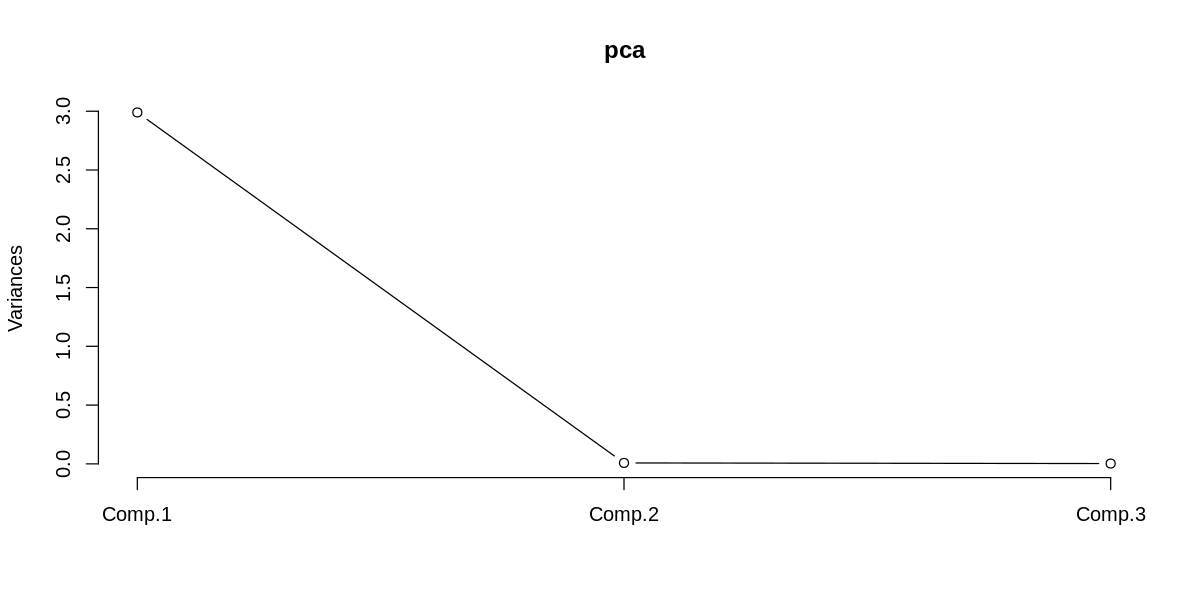

In [33]:
screeplot(pca, type="l")

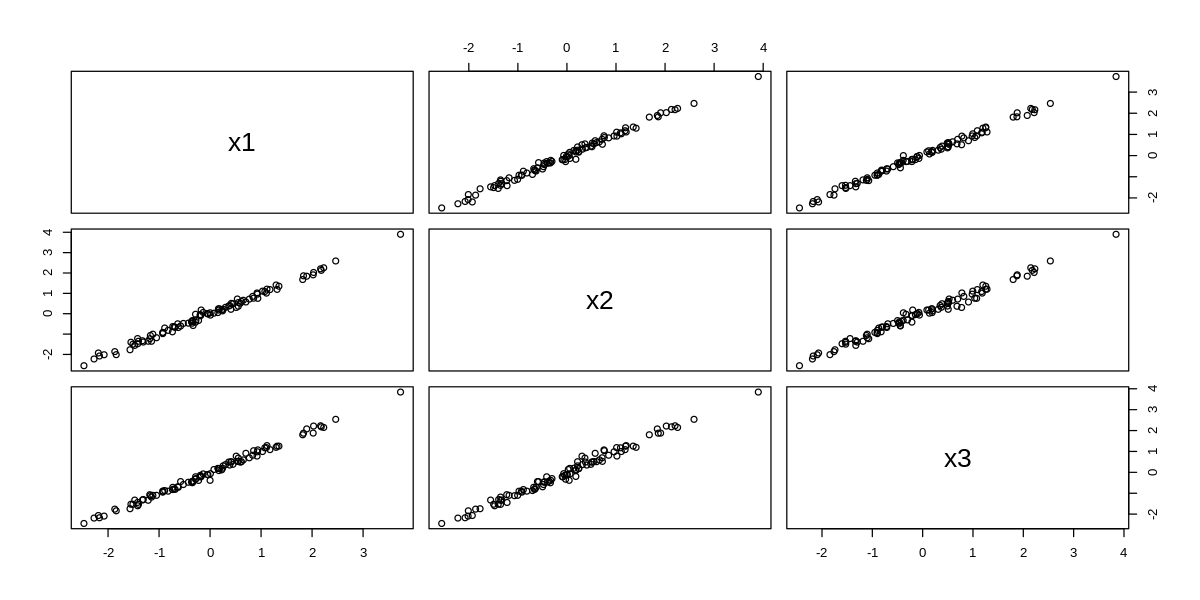

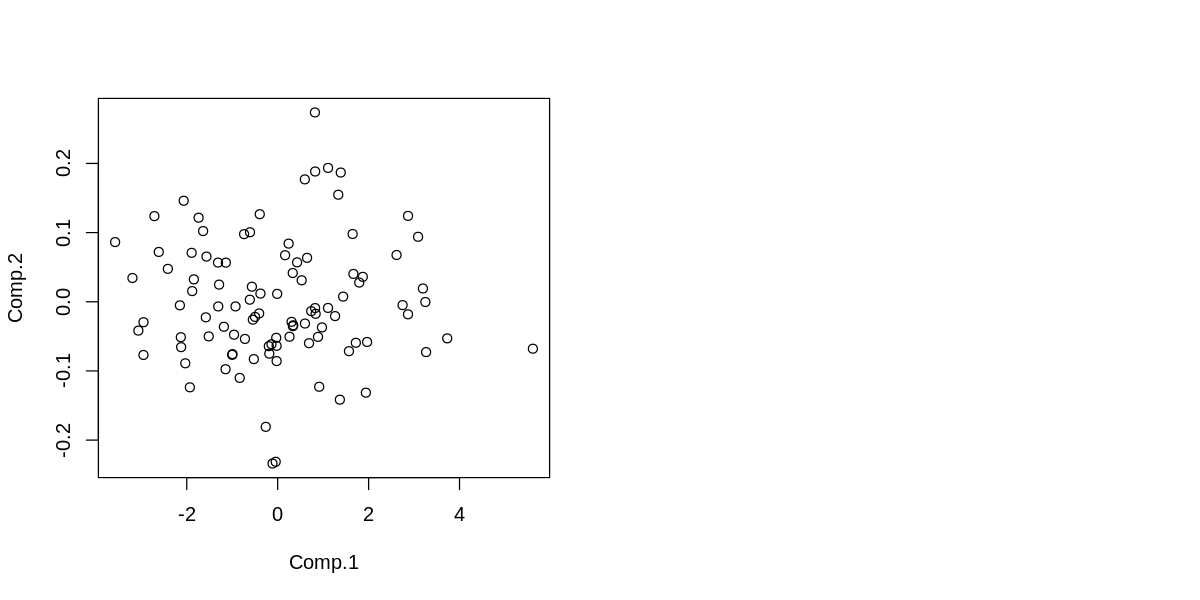

In [34]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1, 2))

Z_pca <- predict(pca, data)
plot(data)
plot(Z_pca)

In [36]:
pca$loadings


Loadings:
   Comp.1 Comp.2 Comp.3
x1  0.578         0.811
x2  0.577 -0.747 -0.329
x3  0.577  0.659 -0.483

               Comp.1 Comp.2 Comp.3
SS loadings     1.000  1.000  1.000
Proportion Var  0.333  0.333  0.333
Cumulative Var  0.333  0.667  1.000

---



### Interpretation of principal components



In [238]:
set.seed(42)

n <- 500
science <- rnorm(n, mean = 60, sd = 10)
humanities <- rnorm(n, mean = 80, sd=10)

df <- tibble(
  math = 0.8 * science + rnorm(n, mean = 0, sd = 7),
  physics = 1.0 * science + rnorm(n, mean = 0, sd = 5),
  chemistry = 1.3 * science + rnorm(n, mean = 0, sd = 3),
  history = 0.8 * humanities + rnorm(n, mean = 0, sd = 5),
  geography = 1.0 * humanities + rnorm(n, mean = 0, sd = 10),
  literature = 1.2 * humanities + rnorm(n, mean = 0, sd = 2)
)

In [239]:
head(df)

math,physics,chemistry,history,geography,literature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75.24308,70.70267,96.57419,75.31981,83.43479,108.93056
47.15127,53.67394,69.82515,71.29549,81.22060,104.36971
57.70016,58.69492,77.54646,63.52407,75.90540,95.74232
55.70171,70.48825,80.20710,67.08787,69.87339,97.44619
44.26261,60.06739,79.38006,61.18328,83.95607,87.11304
42.96862,60.64108,77.71790,62.33062,69.22419,91.85589


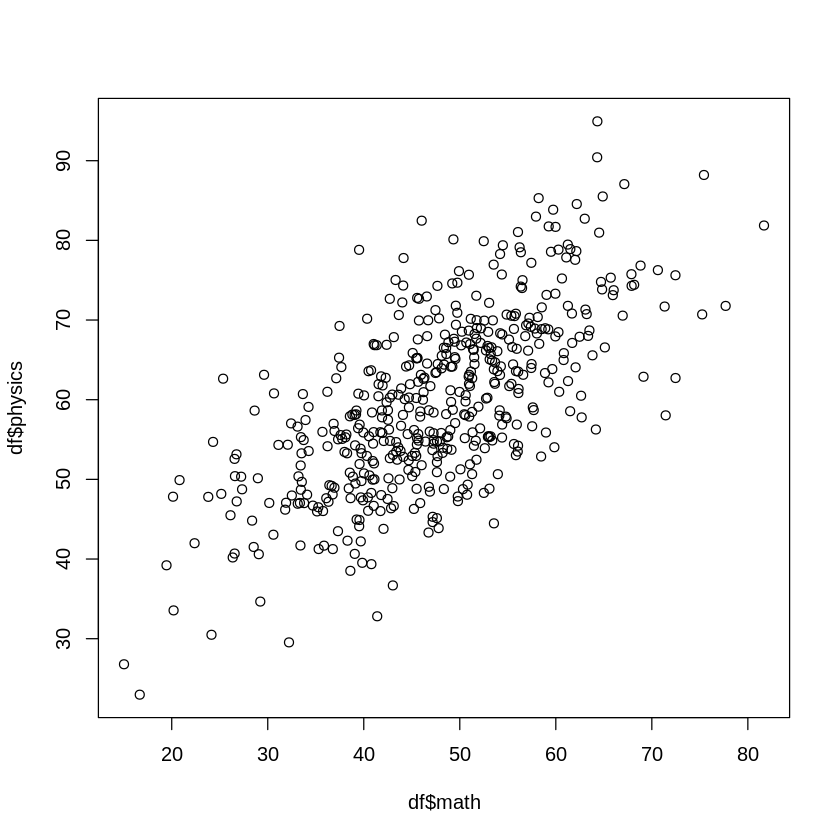

In [240]:
options(repr.plot.width=7, repr.plot.height=7)
plot(df$math, df$physics)

In [242]:
pca <- princomp(df, cor=TRUE)
summary(pca)

Importance of components:
                          Comp.1    Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     1.5860772 1.5585727 0.65113393 0.59751444 0.38083707
Proportion of Variance 0.4192735 0.4048581 0.07066257 0.05950392 0.02417281
Cumulative Proportion  0.4192735 0.8241316 0.89479419 0.95429811 0.97847093
                           Comp.6
Standard deviation     0.35940847
Proportion of Variance 0.02152907
Cumulative Proportion  1.00000000

In [243]:
pca$loadings


Loadings:
           Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
math        0.544                0.820         0.147
physics     0.580               -0.501         0.636
chemistry   0.595               -0.264        -0.755
history            0.572  0.582        -0.571       
geography          0.543 -0.795        -0.261       
literature         0.604  0.159         0.774       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.167  0.167  0.167  0.167  0.167  0.167
Cumulative Var  0.167  0.333  0.500  0.667  0.833  1.000

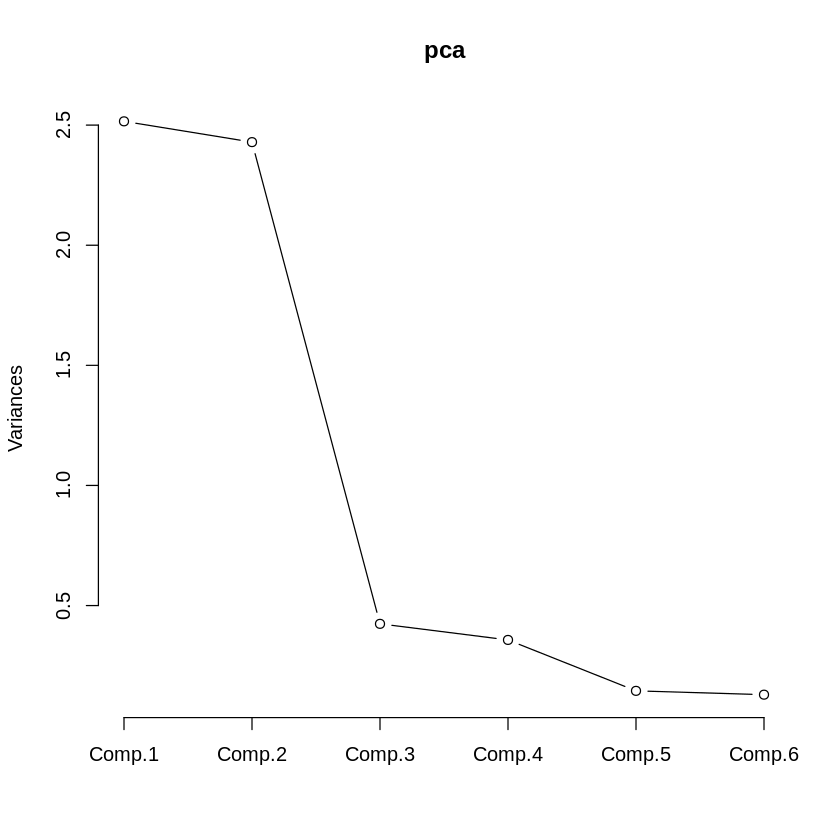

In [244]:
plot(pca, type="l")

---

#### Principal component regression

In [245]:
df$gpa <- (0.9 * science + 0.5 * humanities + rnorm(n, mean=0, sd=10)) * 4 / 100

In [246]:
head(df)

math,physics,chemistry,history,geography,literature,gpa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75.24308,70.70267,96.57419,75.31981,83.43479,108.93056,4.402650
47.15127,53.67394,69.82515,71.29549,81.22060,104.36971,3.414104
57.70016,58.69492,77.54646,63.52407,75.90540,95.74232,3.760019
55.70171,70.48825,80.20710,67.08787,69.87339,97.44619,4.166295
44.26261,60.06739,79.38006,61.18328,83.95607,87.11304,2.963712
42.96862,60.64108,77.71790,62.33062,69.22419,91.85589,3.282428


In [247]:
lm_fit <- lm(gpa ~ ., df)
summary(lm_fit)


Call:
lm(formula = gpa ~ ., data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.12706 -0.29370  0.01835  0.28236  1.25832 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.017263   0.187783  -0.092   0.9268    
math         0.004944   0.002671   1.851   0.0647 .  
physics      0.004557   0.003467   1.315   0.1892    
chemistry    0.018271   0.003217   5.680 2.31e-08 ***
history     -0.004430   0.003469  -1.277   0.2022    
geography    0.002817   0.001873   1.504   0.1332    
literature   0.019673   0.003171   6.205 1.16e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4241 on 493 degrees of freedom
Multiple R-squared:  0.4736,	Adjusted R-squared:  0.4671 
F-statistic: 73.91 on 6 and 493 DF,  p-value: < 2.2e-16


In [248]:
vif(lm_fit) %>% t

math,physics,chemistry,history,geography,literature
2.187701,3.992511,4.760329,3.204141,2.091827,4.368502


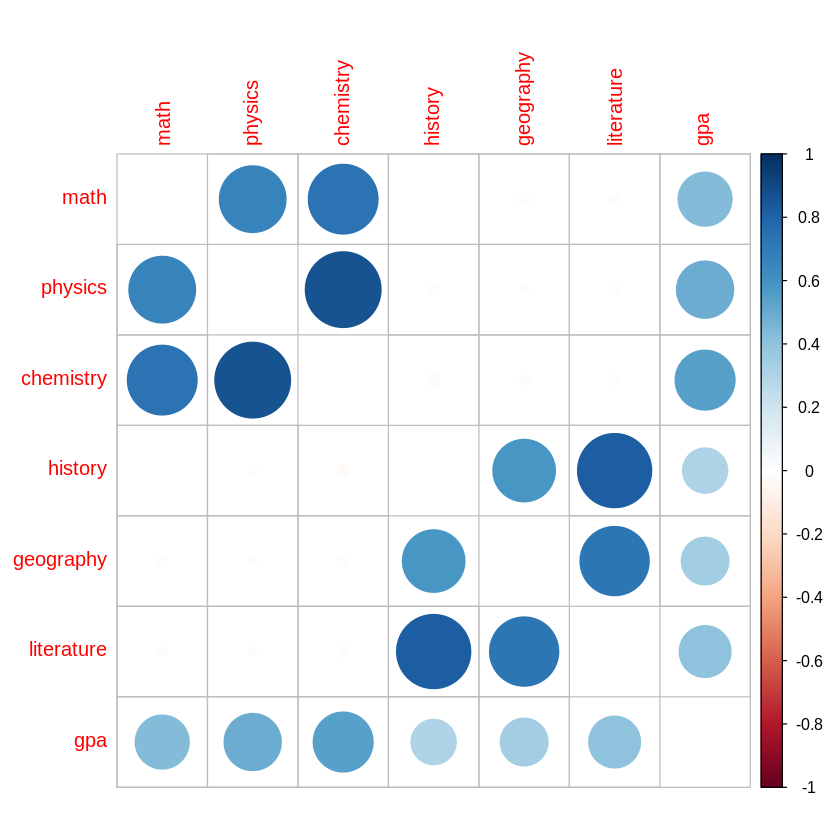

In [249]:
df %>% 
    # select(-gpa) %>% 
    cor() %>% 
    corrplot(diag=F)

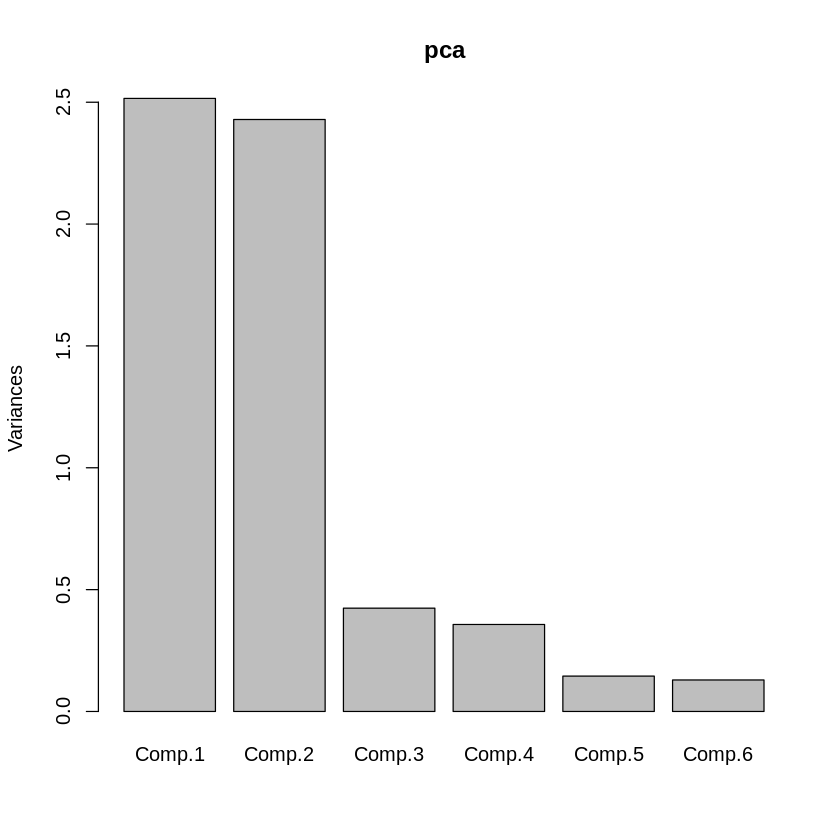

In [250]:
pca <- princomp(df %>% select(-gpa), cor=TRUE)
screeplot(pca)

In [251]:
Z <- predict(pca, df)

df_pca <- Z %>% 
    as_tibble %>% 
    select(Comp.1, Comp.2) %>% 
    mutate(gpa = df$gpa)

head(df_pca)

Comp.1,Comp.2,gpa
<dbl>,<dbl>,<dbl>
2.70377381,1.80787535,4.402650
-0.82432804,0.84294571,3.414104
0.47635843,-0.08509713,3.760019
1.10339233,0.05551303,4.166295
-0.01556033,-0.40923773,2.963712
-0.11975048,-0.67253535,3.282428


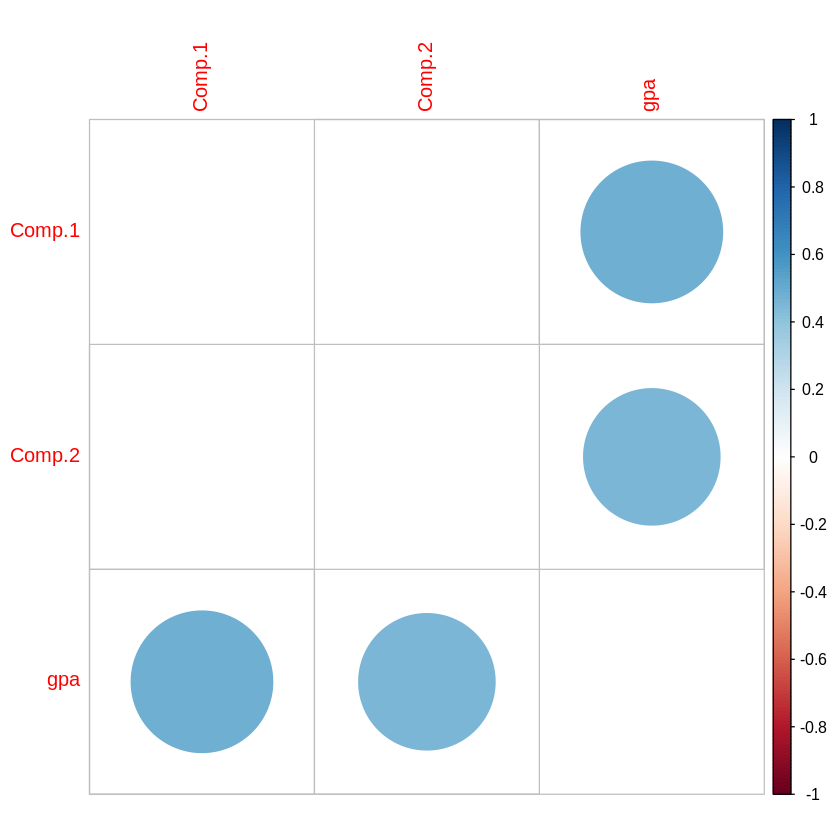

In [252]:
df_pca %>% 
    cor() %>% 
    corrplot(diag=F)

In [254]:
lm_pca <- lm(gpa ~ ., df_pca)
summary(lm_pca)


Call:
lm(formula = gpa ~ ., data = df_pca)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.22601 -0.30774  0.01379  0.28813  1.25162 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.73356    0.01940  192.43   <2e-16 ***
Comp.1       0.17880    0.01223   14.62   <2e-16 ***
Comp.2       0.16893    0.01245   13.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4338 on 497 degrees of freedom
Multiple R-squared:  0.4446,	Adjusted R-squared:  0.4423 
F-statistic: 198.9 on 2 and 497 DF,  p-value: < 2.2e-16


In [52]:
vif(lm_pca) %>% t

Comp.1,Comp.2
1,1


----

# Nonlinear dimension reduction

In [255]:
generate_two_spirals <- function(){
  set.seed(42)
  n <- 500
  noise <- 0.05
  t <- (1:n) / n * 4 * pi
  x1 <- t * (sin(t) + rnorm(n, 0, noise))
  x2 <- t * (cos(t) + rnorm(n, 0, noise))
  y  <- t
  return(tibble(x1=x1, x2=x2, y=y))
}

In [256]:
df <- generate_two_spirals()
head(df)

x1,x2,y
<dbl>,<dbl>,<dbl>
0.002354385,0.02641806,0.02513274
0.001106314,0.05250107,0.05026548
0.007048469,0.07517475,0.07539822
0.013270574,0.10070704,0.10053096
0.018289931,0.12014795,0.12566371
0.021853325,0.14759135,0.15079645


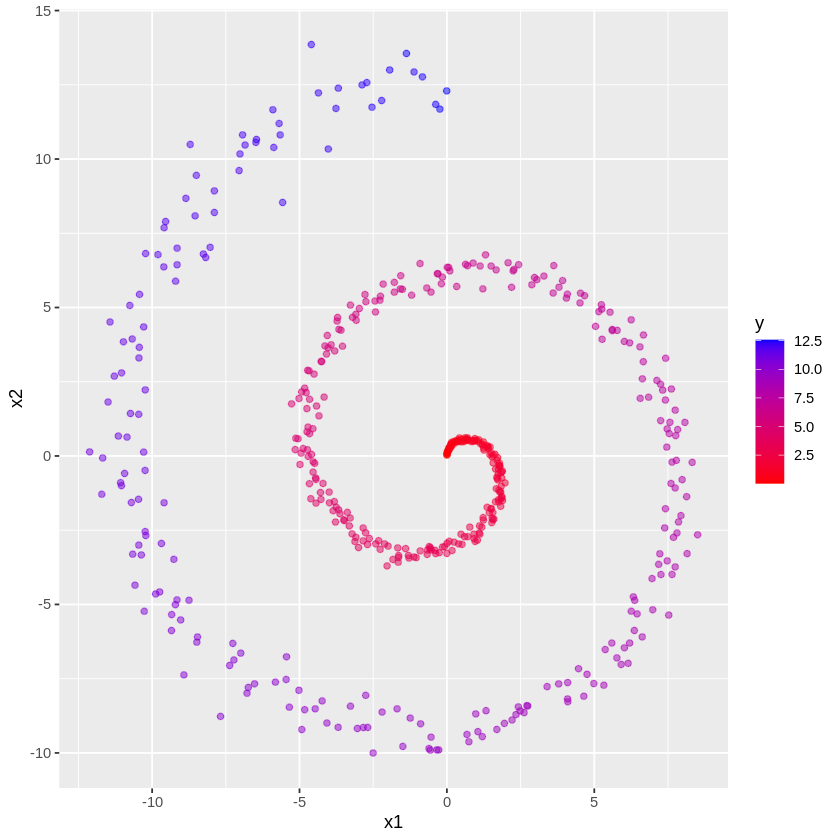

In [257]:
ggplot(df) +
    geom_point(aes(x=x1, y=x2, col=y), alpha=0.5) +
    scale_colour_gradient(low="red", high="blue")

In [258]:
pca <- princomp(df[, 1:2], cor=T)

In [259]:
pca$loadings


Loadings:
   Comp.1 Comp.2
x1  0.707  0.707
x2 -0.707  0.707

               Comp.1 Comp.2
SS loadings       1.0    1.0
Proportion Var    0.5    0.5
Cumulative Var    0.5    1.0

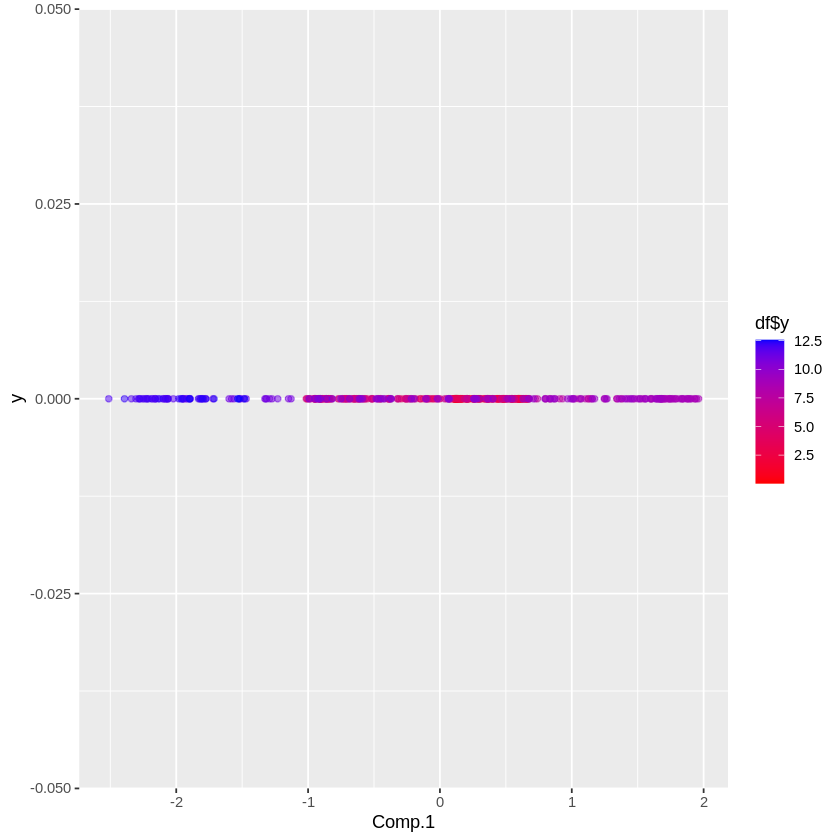

In [260]:
df_pca <- predict(pca, df)

ggplot(as_tibble(df_pca)) +
    geom_point(aes(x=Comp.1, y=0, col=df$y), alpha=0.5) +
    scale_colour_gradient(low="red", high="blue")

In [261]:
library(RDRToolbox)

In [263]:
isomap <- Isomap(df[, 1:2] %>% as.matrix, dims=1)

Computing distance matrix ... 
done

Building graph with shortest paths (using 5 nearest neighbours) ... 
done

Computing low dimensional embedding ... 
done

number of samples: 500

reduction from 2 to 1 dimensions

number of connected components in graph: 1



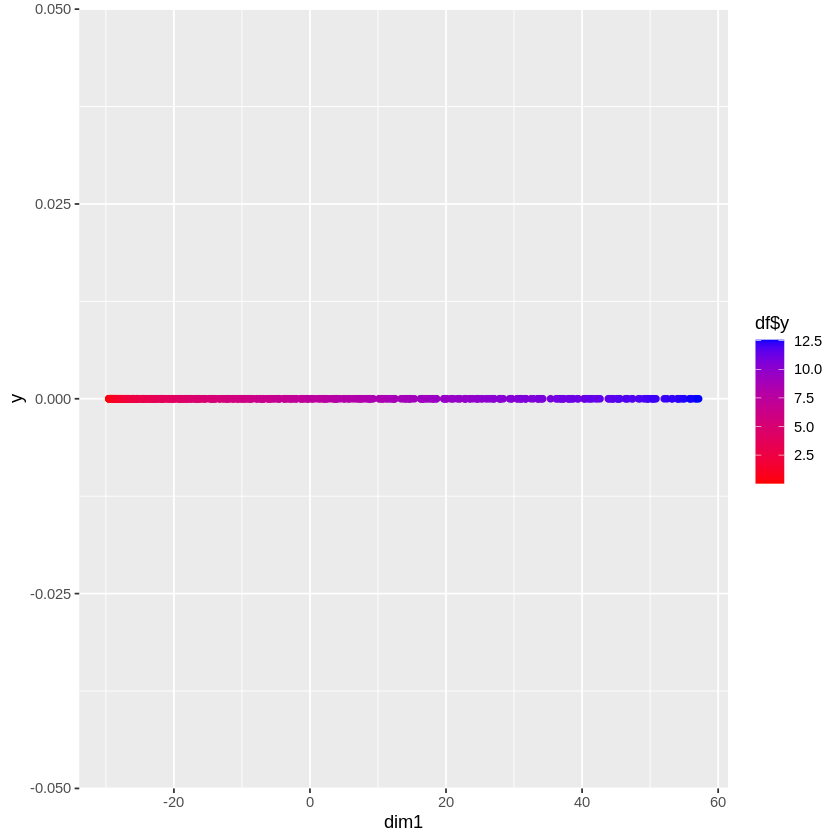

In [264]:
ggplot(as_tibble(isomap)) +
    geom_point(aes(x=dim1, y=0, col=df$y)) +
    scale_colour_gradient(low="red", high="blue")

---

# Autoencoder


![Autoencoder](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ydTBLRhllAgnqXUO5CSonQ.png)


[image source](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ydTBLRhllAgnqXUO5CSonQ.png)

In [208]:
autoencoder <- nn_module(
    initialize = function(p, q1, q2, q3, o) {
    self$encoder <- nn_sequential(
        nn_linear(p, q1), nn_relu(),
        nn_linear(q1, q2), nn_relu(),
        nn_linear(q2, q3), nn_relu(),
        nn_linear(q3, o)
    )
    self$decoder <- nn_sequential(
        nn_linear(o, q3), nn_relu(),
        nn_linear(q3, q2), nn_relu(),
        nn_linear(q2, q1), nn_relu(),
        nn_linear(q1, p)
    )
    },
    forward = function(x) {
    x %>%
        torch_reshape(c(-1, 28 * 28)) %>% 
        self$encoder() %>%
        self$decoder() %>% 
        torch_reshape(c(-1, 28, 28))
    },
    predict = function(x) {
    x %>% 
        torch_reshape(c(-1, 28 * 28)) %>% 
        self$encoder()     
    }
)

In [265]:
X <- test_ds
inputs <- torch_tensor(X$data * 1.0)
AE <- autoencoder(p=28*28, q1=32, q2=16, q3=8, o=2)

In [266]:
plot_image = \(x) image(t(x)[1:28, 28:1], useRaster=TRUE, axes=FALSE, col=gray.colors(1000))

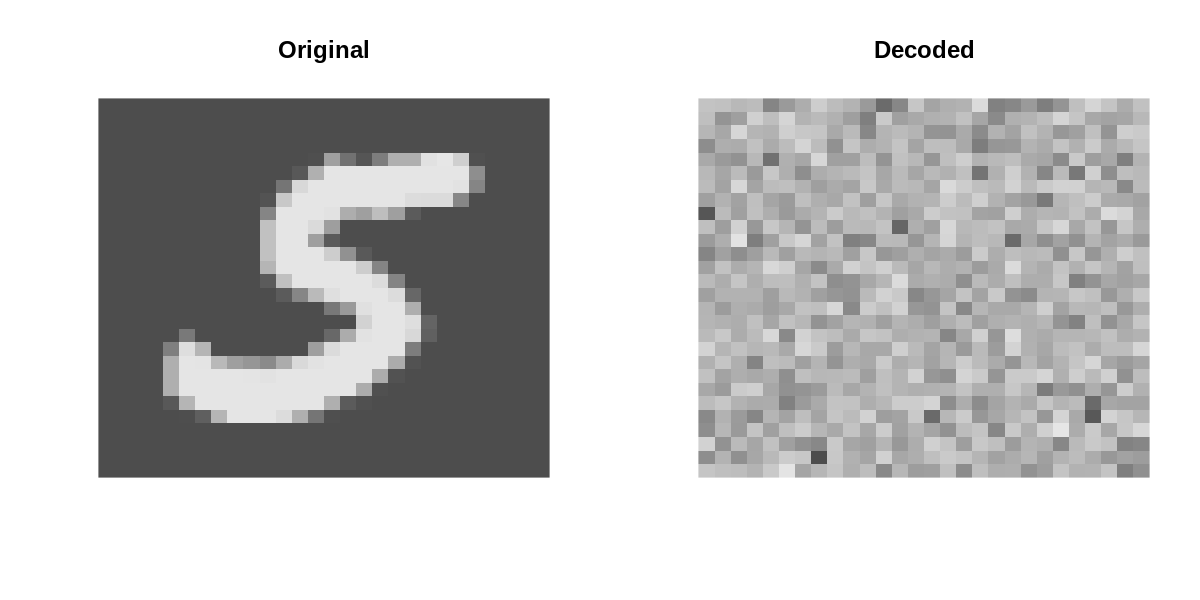

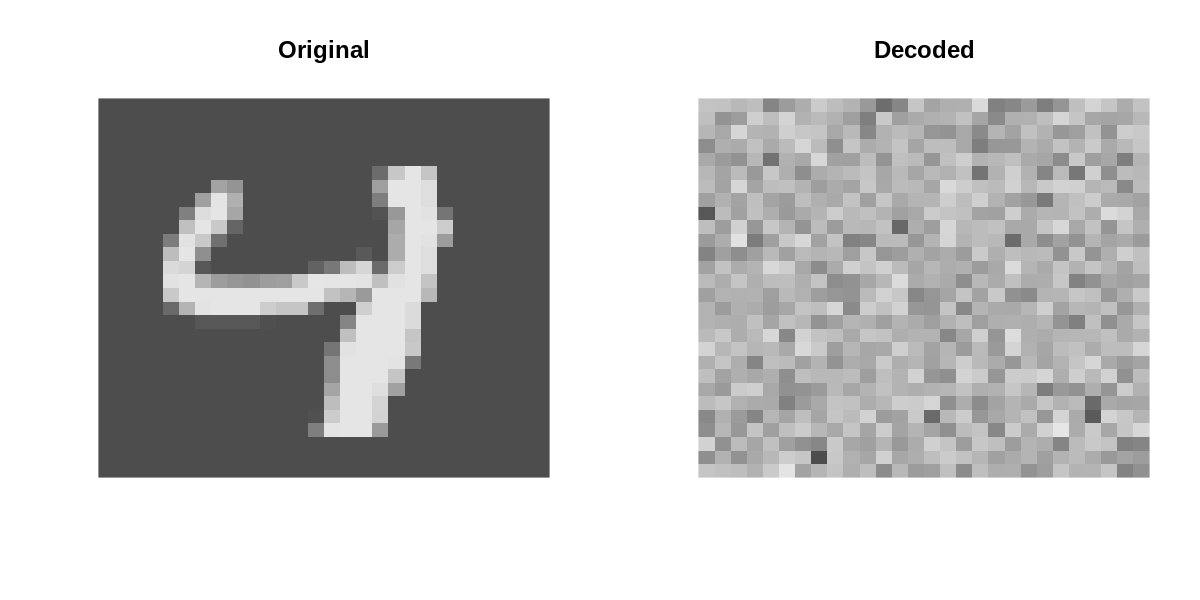

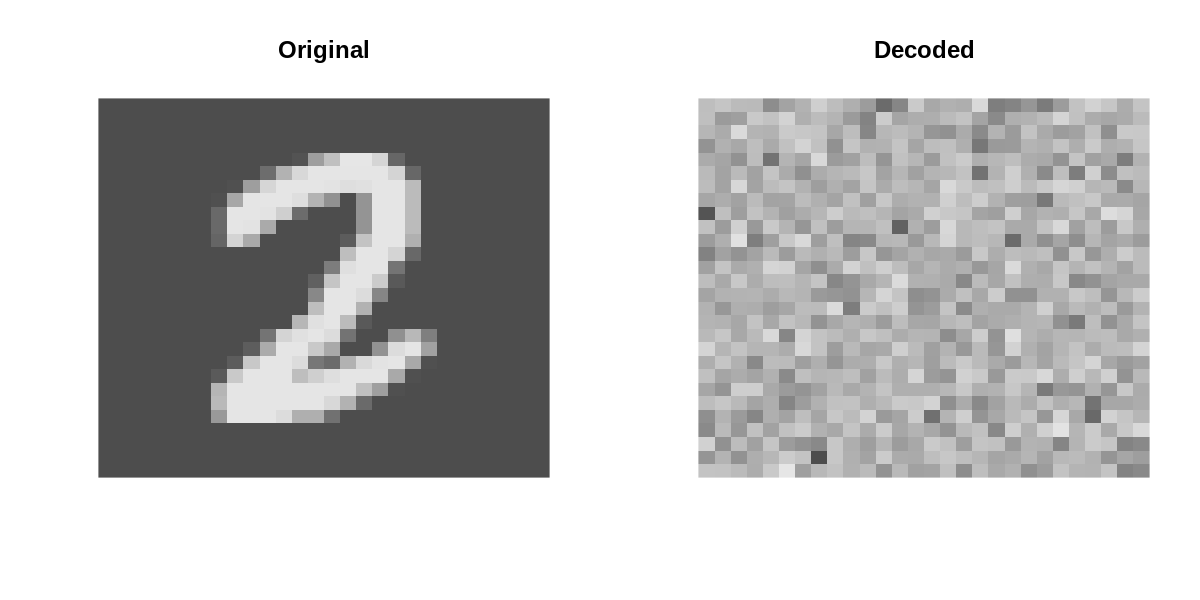

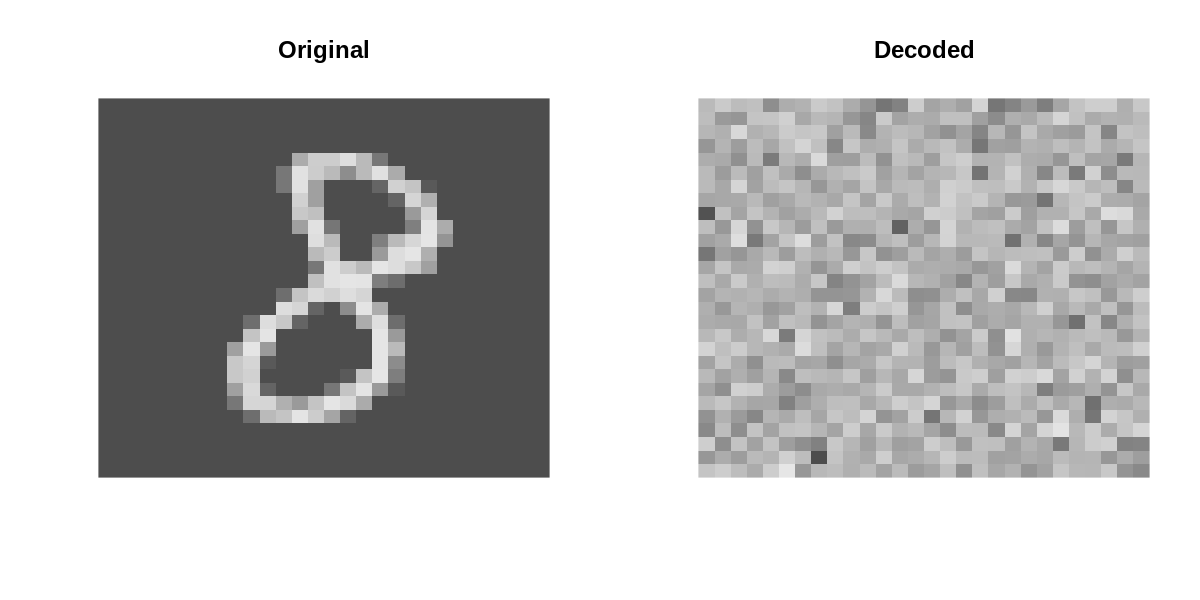

In [413]:
options(repr.plot.width=10, repr.plot.height=5)

par(mfrow=c(4, 2))


for(k in 1:4){
    i <- sample(1:10000, 1)
    input <- inputs[i]
    output <- AE(inputs[i:i])[1]

    par(mfrow=c(1, 2))
    plot_image(inputs[i] %>% as_array)
    title("Original")
    
    plot_image(output %>% as_array)
    title("Decoded")
}

In [512]:
ae_fit <- autoencoder %>%
    setup(
        loss = nn_mse_loss(),
        optimizer = optim_adam
    ) %>%

    set_hparams(
        p=28*28, q1=128, q2=32, q3=8, o=2
    ) %>%
    
    set_opt_hparams(
        lr=1e-3
    ) %>%

    fit(
        data = list(inputs, inputs),
        epochs=100,
        verbose=TRUE,
        dataloader_options = list(batch_size = 500, shuffle=TRUE),
        callbacks = list(
            luz_callback_lr_scheduler(torch::lr_step, step_size = 5, gamma=1.05)
        )
    )

Epoch 1/100
Train metrics: Loss: 6660.0813
Epoch 2/100
Train metrics: Loss: 4406.1622
Epoch 3/100
Train metrics: Loss: 4152.6708
Epoch 4/100
Train metrics: Loss: 4128.6068
Epoch 5/100
Train metrics: Loss: 4124.6459
Epoch 6/100
Train metrics: Loss: 4124.1289
Epoch 7/100
Train metrics: Loss: 4123.9013
Epoch 8/100
Train metrics: Loss: 4123.4541
Epoch 9/100
Train metrics: Loss: 4123.6108
Epoch 10/100
Train metrics: Loss: 4122.3257
Epoch 11/100
Train metrics: Loss: 4118.8177
Epoch 12/100
Train metrics: Loss: 4101.1852
Epoch 13/100
Train metrics: Loss: 3997.9334
Epoch 14/100
Train metrics: Loss: 3831.0511
Epoch 15/100
Train metrics: Loss: 3780.8247
Epoch 16/100
Train metrics: Loss: 3736.6454
Epoch 17/100
Train metrics: Loss: 3687.9492
Epoch 18/100
Train metrics: Loss: 3658.5471
Epoch 19/100
Train metrics: Loss: 3637.2938
Epoch 20/100
Train metrics: Loss: 3617.9976
Epoch 21/100
Train metrics: Loss: 3598.4399
Epoch 22/100
Train metrics: Loss: 3570.1786
Epoch 23/100
Train metrics: Loss: 3538.62

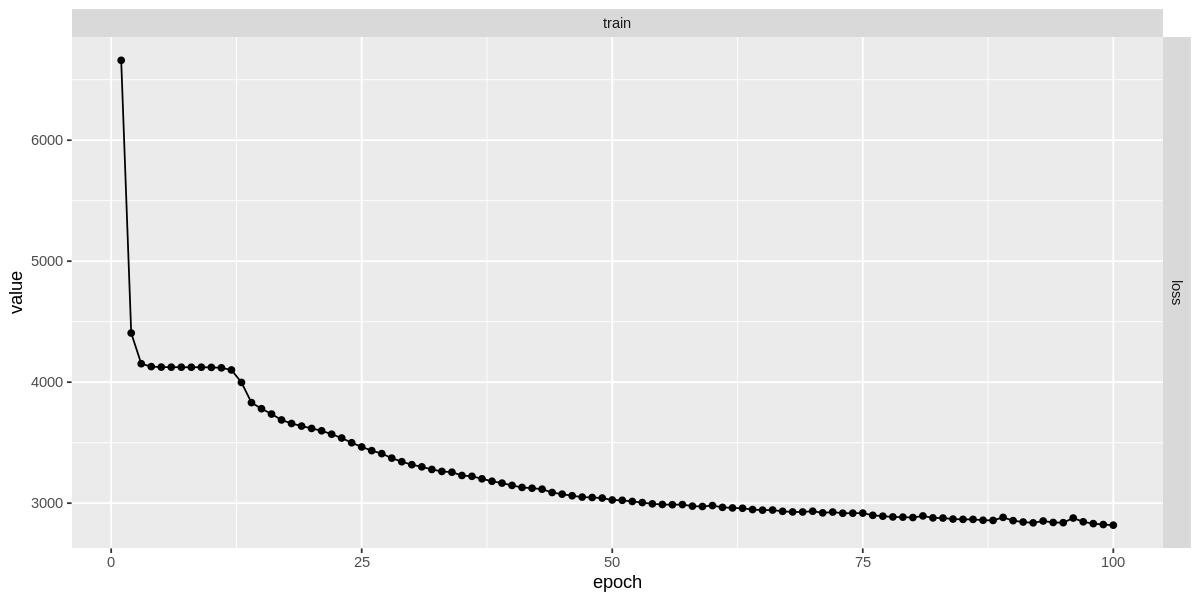

In [513]:
plot(ae_fit)

In [514]:
X_dim2 <- predict(ae_fit, inputs) %>% as_array()
head(X_dim2)

-493.0910,-262.1256
-742.4239,135.2995
-518.8569,220.9595
-1217.0292,-212.7058
-144.5060,-294.5141
-697.5718,295.3368


In [515]:
df_ae <- tibble(
    x1 = X_dim2[, 1],
    x2 = X_dim2[, 2],
    y = as.factor(X$targets - 1)
)

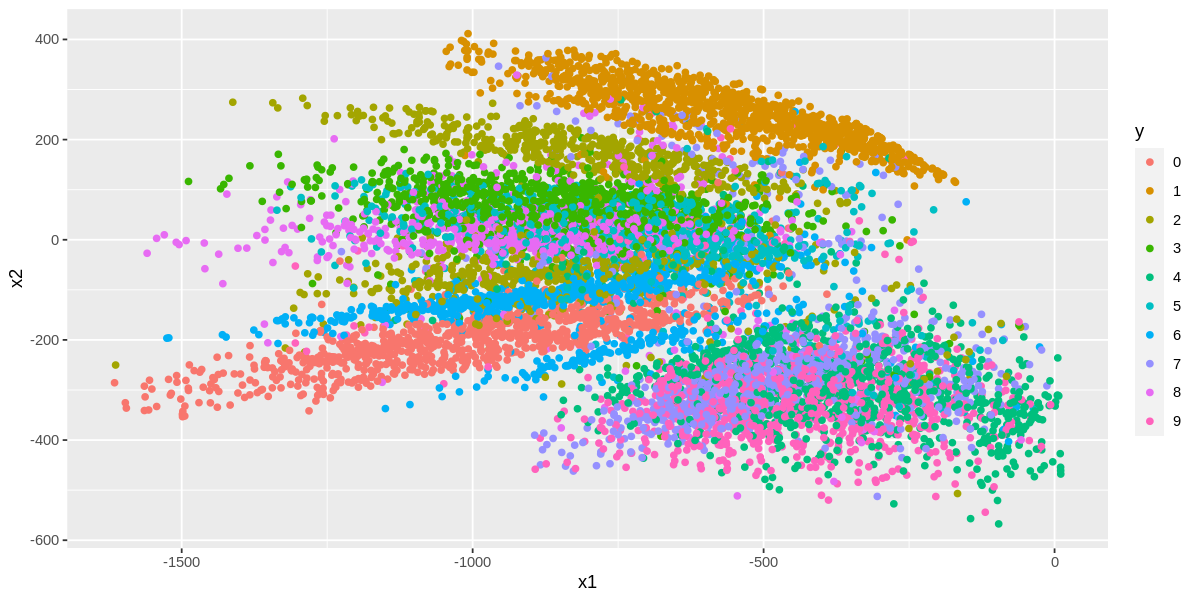

In [516]:
ggplot(df_ae) +
    geom_point(aes(x=x1, y=x2, col=y))

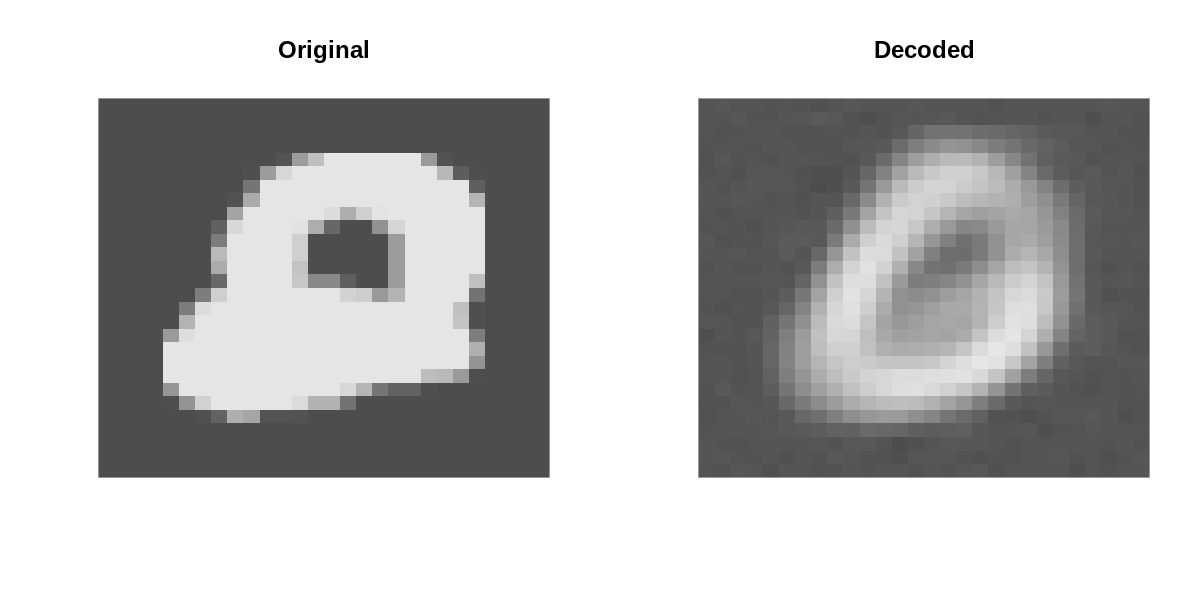

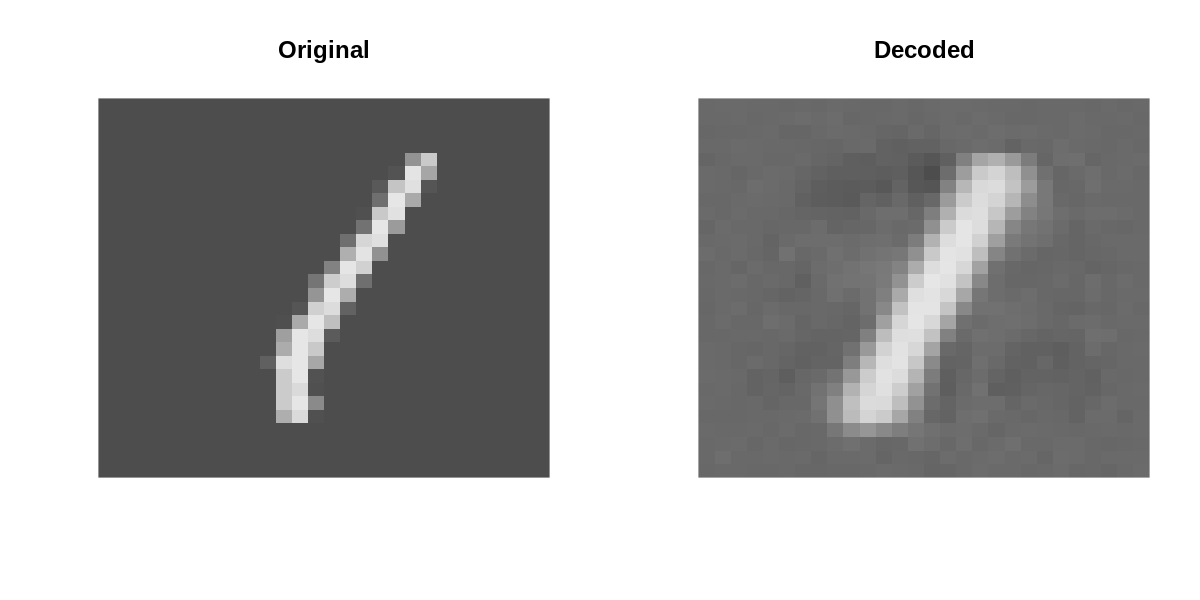

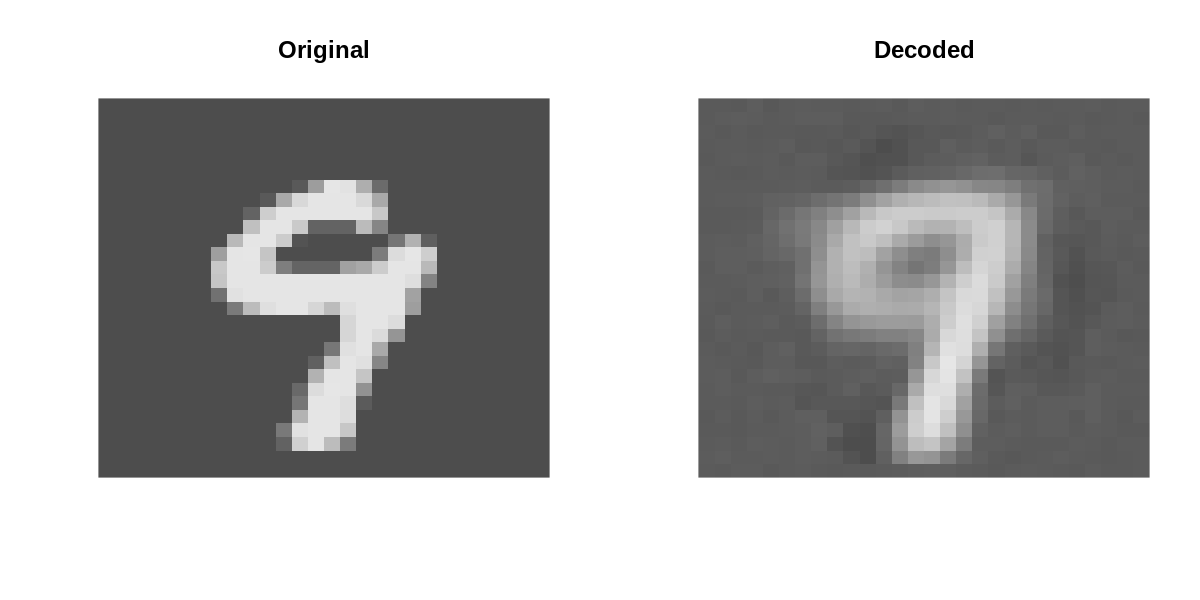

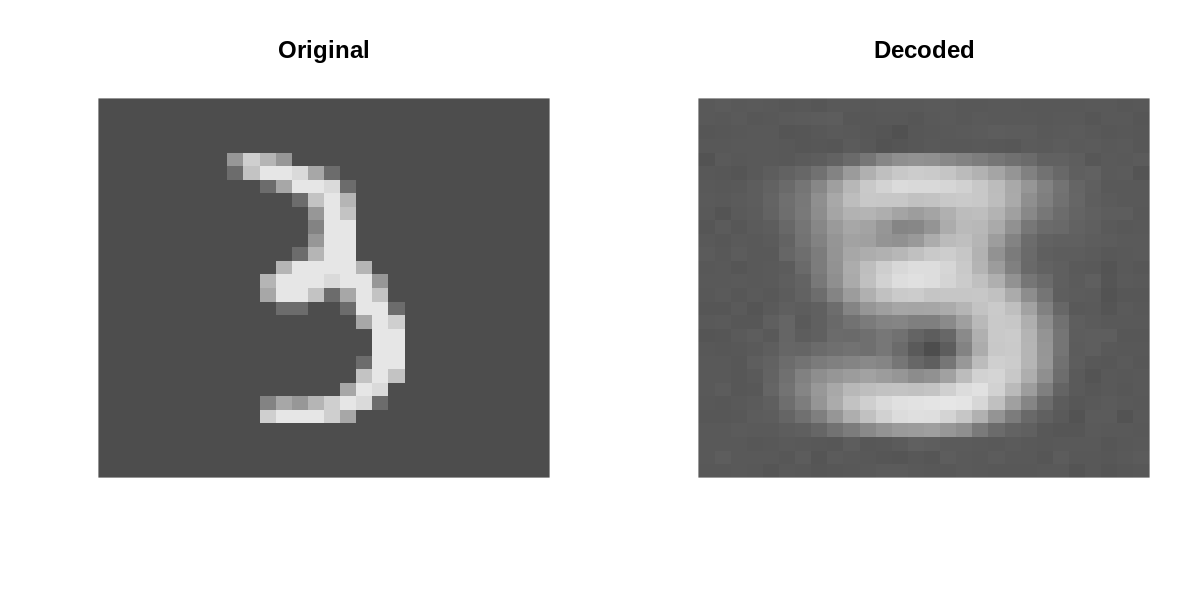

In [521]:
options(repr.plot.width=10, repr.plot.height=5)

par(mfrow=c(4, 2))


set.seed(123)
for(k in 1:4){
    i <- sample(1:10000, 1)
    input <- inputs[i]
    output <- ae_fit$model$forward(inputs[i:i])[1]

    par(mfrow=c(1, 2))
    plot_image(inputs[i] %>% as_array)
    title("Original")
    
    plot_image(output %>% as_array)
    title("Decoded")
}